<a href="https://colab.research.google.com/github/Shoab02/YComplaints/blob/main/models/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
openjdk version "11.0.17" 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)


In [2]:
!pip install h2o


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.38.0.4-py2.py3-none-any.whl size=177628739 sha256=03187cc617bc5c7f1802ccaacf50de277bf8a4c4bf044cf9d161e8a010d62382
  Stored in directory: /root/.cache/pip/wheels/6b/1d/65/39927b5984bde22f615b4c6e9a8ee98ea4abf1acb5926623ff
Successfully built h2o


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML

In [4]:
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf6bka8pp
  JVM stdout: /tmp/tmpf6bka8pp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpf6bka8pp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_6rhosh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [5]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
df=pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true', compression='zip', sep=',', quotechar='"')


In [7]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57448,2/29/2020,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I am attempting to make a payment toward my st...,None,"Nelnet, Inc.",KS,None,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549178
57449,2/11/2020,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,Received letter for {$480.00}. Original credit...,Company has responded to the consumer and the ...,"The Receivable Management Services LLC, New Yo...",AZ,853XX,None,Consent provided,Web,2/18/2020,Closed with explanation,Yes,NaN,3527928
57450,2/29/2020,Debt collection,Other debt,Communication tactics,"Used obscene, profane, or other abusive language",entire time 10 years until XX/XX/2020. XXXX ma...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,8101,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549238
57451,1/16/2020,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I am a customer with Wells Fargo Bank. Recentl...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,852XX,None,Consent provided,Web,1/22/2020,Closed with explanation,Yes,NaN,3498566


In [8]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

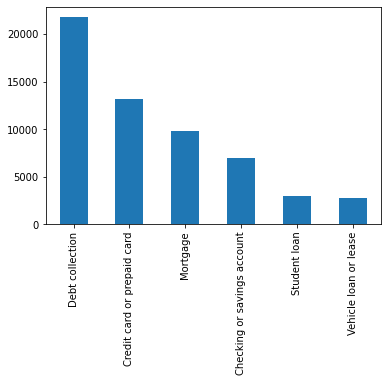

In [9]:
df['Product'].value_counts().plot(kind='bar')


In [10]:
df['Company'].value_counts()


CITIBANK, N.A.                                                    3226
CAPITAL ONE FINANCIAL CORPORATION                                 2711
BANK OF AMERICA, NATIONAL ASSOCIATION                             2580
JPMORGAN CHASE & CO.                                              2409
WELLS FARGO & COMPANY                                             2001
                                                                  ... 
Time Investment Company, Inc.                                        1
Automotive Services Finance, Inc.                                    1
Foxstar Energy Resources LLC DBA Federal Student Loans Council       1
Uplift, Inc                                                          1
Keystone Credit Services LLC                                         1
Name: Company, Length: 2197, dtype: int64

In [11]:
complaints_df=df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})


In [12]:

pd.set_option('display.max_colwidth', -1)
complaints_df

<ipython-input-12-704451e25f62>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,complaints,Product,Company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never

In [13]:
target={'Debt collection':0, 'Credit card or prepaid card':1, 'Mortgage':2, 'Checking or savings account':3, 'Student loan':4, 'Vehicle loan or lease':5}
complaints_df['target']=complaints_df['Product'].map(target)


In [14]:
complaints_df

,complaints,Product,Company,target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked

In [15]:
X_train, X_test = train_test_split(complaints_df, test_size=0.2, random_state=111)


In [16]:
stemmer = nltk.stem.SnowballStemmer('english')

In [17]:

nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:

def tokenize(text):
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   tokens = map(str.lower, tokens)
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

In [19]:
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.complaints) 

In [20]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05982325, 0.        , ..., 0.        , 0.        ,
        0.04799057],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09582677],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [21]:
vectorizer_tf.get_feature_names()


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'access account',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account bank',
 'account call',
 'account close',
 'account credit',
 'account inform',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'act',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 'arrang',
 'arriv',
 'ask',
 'assess',
 'asset',
 'assign',

In [22]:
test_vectors = vectorizer_tf.transform(X_test.complaints)


In [23]:
X_train.shape
X_test.shape


(11491, 4)

In [24]:

train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)], axis=1)
train_df

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,...,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012890,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
1,0.0,0.059823,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.047991,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.031230,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.127589,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45957,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
45958,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.103417,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,2
45959,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.059808,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.095827,1
45960,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1


In [25]:

test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)], axis=1)
test_df
     

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,...,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.086926,0.0,0.0,0.0,0.211931,0.0,0.0,0.348174,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,3
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.124616,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,2
2,0.0,0.144146,0.0,0.0,0.0,0.000000,0.0,0.0,0.216513,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,1
3,0.0,0.088468,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.04532,0.0,0.0,0.0,0.0,0.0,0.070970,4
4,0.0,0.079915,0.0,0.0,0.0,0.000000,0.0,0.0,0.040012,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.128217,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.020533,0.0,...,0.0,0.129516,0.00000,0.0,0.0,0.0,0.0,0.0,0.032899,1
11487,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.183305,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,4
11488,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.139304,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,2
11489,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.077799,0


In [26]:

h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [27]:
h2o_train_df.types


{'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'access account': 'real',
 'accord': 'real',
 'account': 'real',
 'account account': 'real',
 'account balanc': 'real',
 'account bank': 'real',
 'account call': 'real',
 'account close': 'real',
 'account credit': 'real',
 'account inform': 'real',
 'account number': 'real',
 'account open': 'real',
 'account report': 'real',
 'account would': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'act': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advantag': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': 'real',
 'agent': 'real',
 'agre': 'real',
 'agreement': 'real',
 'alert': 'real',
 'alleg': 'real',
 'alleg debt': 'real',
 'alli': 'real',
 'allow'

In [28]:

h2o_train_df['target'] = h2o_train_df['target'].asfactor()
h2o_test_df['target'] = h2o_test_df['target'].asfactor()

In [29]:
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble"], verbosity="info", nfolds=0, balance_classes=True, max_after_balance_size=0.3)


In [30]:

x=vectorizer_tf.get_feature_names()
y='target'
     

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
aml.train(x = x, y = y, training_frame = h2o_train_df, validation_frame=h2o_test_df)


AutoML progress: |
20:49:53.884: Project: AutoML_1_20230117_204953
20:49:53.885: Cross-validation disabled by user: no fold column nor nfolds > 1.
20:49:53.905: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
20:49:53.905: Build control seed: 10
20:49:53.908: training frame: Frame key: AutoML_1_20230117_204953_training_py_1_sid_acb7    cols: 1001    rows: 45962  chunks: 53    size: 38316570  checksum: 6329493770984812808
20:49:53.914: validation frame: Frame key: py_2_sid_acb7    cols: 1001    rows: 11491  chunks: 14    size: 9659181  checksum: -4436412281815890274
20:49:53.915: leaderboard frame: Frame key: py_2_sid_acb7    cols: 1001    rows: 11491  chunks: 14    size: 9659181  checksum: -4436412281815890274
20:49:53.915: blending frame: NULL
20:49:53.915: response column: target
20:49:53.915: fold column: null
20:49:53.915: weights column: null
20:49:53.946: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w)

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_2_AutoML_1_20230117_204953


Model Summary: 
    number_of_trees
--  -----------------
    105

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.03249177675455408
RMSE: 0.18025475515101974
LogLoss: 0.11976291391885924
Mean Per-Class Error: 0.03981002906795597
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0      1      2     3     4     5     Error      Rate
-----  -----  ----  ----  ----  ----  ---------  --------------
17167  176    55    38    16    25    0.0177376  310 / 17,477
246    10256  13    77    8     10    0.0333648  354 / 10,610
79     46     7630  17    6     6     0.0197842  154 / 7,784
67     87     5     5378  0     5     0.0295922  164 / 5,542
57     45     7     1     2227  2     0.0478837  112 / 2,339
118    62     9     5     6     2010  0.0904977  200 / 2,210
17734  10672  7719  5516  2263  2058  0.0281537  1,294 / 45,962

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.971846
2    0.993408
3    0.997977
4    0.999434
5    0.999891
6    1

ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.0938965180236247
RMSE: 0.30642538736799324
LogLoss: 0.3231046810525456
Mean Per-Class Error: 0.15383952296271095
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0     1     2     3     4    5    Error      Rate
----  ----  ----  ----  ---  ---  ---------  --------------
4007  125   52    26    39   46   0.0670547  288 / 4,295
170   2280  21    93    2    17   0.117305   303 / 2,583
68    29    1866  14    6    32   0.0739454  149 / 2,015
46    127   19    1264  1    4    0.134839   197 / 1,461
61    19    17    1     494  19   0.191489   117 / 611
93    37    32    9     7    348  0.338403   178 / 526
4445  2617  2007  1407  549  466  0.107214   1,232 / 11,491

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.892786
2    0.966583
3    0.986598
4    0.99443
5    0.998085
6    1

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_logloss     training_classification_error    training_auc    training_pr_auc    validation_rmse      validation_logloss    validation_classification_error    validation_auc    validation_pr_auc
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------------------  --------------  -----------------  -------------------  --------------------  ---------------------------------  ----------------  -------------------
     2023-01-17 21:15:40  0.008 sec         0.0                0.8333333283662738   1.7917594394257323   0.8306427048431313               nan             nan                0.8333333283662738   1.7917594394257323    0.8246453746410234                 nan               nan
     2023-01-17 21:15:47  7.511 sec         5.0                0.45514288516471885  0.6264434610698137   0.12220965145119882              nan             nan                0.4727826347666558   0.6696040782414554    0.1488991384561831                 nan               nan
     2023-01-17 21:15:51  11.480 sec        10.0               0.3498713076417903   0.4042554719994132   0.10410774117749445              nan             nan                0.3832

In [32]:
aml.leaderboard


model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_2_AutoML_1_20230117_204953,0.15384,0.323105,0.306425,0.0938965
GBM_1_AutoML_1_20230117_204953,0.156483,0.363885,0.326403,0.106539
XGBoost_1_AutoML_1_20230117_204953,0.156655,0.327174,0.308112,0.0949329
XGBoost_3_AutoML_1_20230117_204953,0.157917,0.32842,0.312655,0.0977533
GBM_4_AutoML_1_20230117_204953,0.158289,0.388788,0.339003,0.114923
GLM_1_AutoML_1_20230117_204953,0.166259,0.36789,0.32727,0.107106
GBM_3_AutoML_1_20230117_204953,0.166284,0.386871,0.340575,0.115991
GBM_2_AutoML_1_20230117_204953,0.169216,0.390114,0.342264,0.117145
XRT_1_AutoML_1_20230117_204953,0.278739,0.593462,0.444369,0.197464
DRF_1_AutoML_1_20230117_204953,0.288439,0.590951,0.442465,0.195775


In [33]:
pred=aml.leader.predict(h2o_test_df)


xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [34]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.0938965180236247
RMSE: 0.30642538736799324
LogLoss: 0.3231046810525456
Mean Per-Class Error: 0.15383952296271095
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0     1     2     3     4    5    Error      Rate
----  ----  ----  ----  ---  ---  ---------  --------------
4007  125   52    26    39   46   0.0670547  288 / 4,295
170   2280  21    93    2    17   0.117305   303 / 2,583
68    29    1866  14    6    32   0.0739454  149 / 2,015
46    127   19    1264  1    4    0.134839   197 / 1,461
61    19    17    1     494  19   0.191489   117 / 611
93    37    32    9     7    348  0.338403   178 / 526
4445  2617  2007  1407  549  466  0.107214   1,232 / 11,491

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.892786
2    0.966583
3    0.986598
4    0.99443
5    0.998085
6    1

In [42]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
     

In [43]:
out


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_2_AutoML_1_20230117_204953


Model Summary: 
    number_of_trees
--  -----------------
    105

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.03249177675455408
RMSE: 0.18025475515101974
LogLoss: 0.11976291391885924
Mean Per-Class Error: 0.03981002906795597
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0      1      2     3     4     5     Error      Rate
-----  -----  ----  ----  ----  ----  ---------  --------------
17167  176    55    38    16    25    0.0177376  310 / 17,477
246    10256  13    77    8     10    0.0333648  354 / 10,610
79     46     7630  17    6     6     0.0197842  154 / 7,784
67     87     5     5378  0     5     0.0295922  164 / 5,542
57     45     7     1     2227  2     0.0478837  112 / 2,339
118    62     9     5     6     2010  0.0904977  200 / 2,210
17734  10672  7719  5516  2263  2058  0.0281537  1,294 / 45,962

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.971846
2    0.993408
3    0.997977
4    0.999434
5    0.999891
6    1

ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.0938965180236247
RMSE: 0.30642538736799324
LogLoss: 0.3231046810525456
Mean Per-Class Error: 0.15383952296271095
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0     1     2     3     4    5    Error      Rate
----  ----  ----  ----  ---  ---  ---------  --------------
4007  125   52    26    39   46   0.0670547  288 / 4,295
170   2280  21    93    2    17   0.117305   303 / 2,583
68    29    1866  14    6    32   0.0739454  149 / 2,015
46    127   19    1264  1    4    0.134839   197 / 1,461
61    19    17    1     494  19   0.191489   117 / 611
93    37    32    9     7    348  0.338403   178 / 526
4445  2617  2007  1407  549  466  0.107214   1,232 / 11,491

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.892786
2    0.966583
3    0.986598
4    0.99443
5    0.998085
6    1

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_logloss     training_classification_error    training_auc    training_pr_auc    validation_rmse      validation_logloss    validation_classification_error    validation_auc    validation_pr_auc
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------------------  --------------  -----------------  -------------------  --------------------  ---------------------------------  ----------------  -------------------
     2023-01-17 21:15:40  0.008 sec         0.0                0.8333333283662738   1.7917594394257323   0.8306427048431313               nan             nan                0.8333333283662738   1.7917594394257323    0.8246453746410234                 nan               nan
     2023-01-17 21:15:47  7.511 sec         5.0                0.45514288516471885  0.6264434610698137   0.12220965145119882              nan             nan                0.4727826347666558   0.6696040782414554    0.1488991384561831                 nan               nan
     2023-01-17 21:15:51  11.480 sec        10.0               0.3498713076417903   0.4042554719994132   0.10410774117749445              nan             nan                0.3832

In [44]:
out.convert_H2OXGBoostParams_2_XGBoostParams()


({'silent': True,
  'updater': 'grow_gpu_hist',
  'eta': 0.3,
  'objective': 'multi:softprob',
  'min_child_weight': 5.0,
  'nthread': 2,
  'seed': 13,
  'num_class': 6,
  'max_bin': 256,
  'max_depth': 10,
  'colsample_bytree': 0.8,
  'lambda': 1.0,
  'gamma': 0.0,
  'gpu_id': 0,
  'alpha': 0.0,
  'booster': 'gbtree',
  'grow_policy': 'depthwise',
  'nround': 10000,
  'subsample': 0.6,
  'max_delta_step': 0.0,
  'colsample_bylevel': 0.8},
 10000)

In [45]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
     

In [46]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})
     

In [47]:
xgb_clf.fit(train_vectors, X_train['target'])


[22:03:04] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(learning_rate=0.05, max_depth=6, objective='multi:softprob',
              random_state=10, updater='grow_gpu')

In [48]:
predictions = xgb_clf.predict(test_vectors)


In [49]:

cm = confusion_matrix(X_test['target'], predictions)
print(cm)
     

[[3938  160   60   39   44   54]
 [ 275 2181   12  101    1   13]
 [  96   38 1822   23    8   28]
 [  90  131   21 1211    0    8]
 [  77   23   29    2  461   19]
 [ 106   55   35    9    3  318]]


In [50]:
print('classification_report :\n',classification_report(X_test['target'], predictions))


classification_report :
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      4295
           1       0.84      0.84      0.84      2583
           2       0.92      0.90      0.91      2015
           3       0.87      0.83      0.85      1461
           4       0.89      0.75      0.82       611
           5       0.72      0.60      0.66       526

    accuracy                           0.86     11491
   macro avg       0.85      0.81      0.83     11491
weighted avg       0.86      0.86      0.86     11491



In [57]:

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight( class_weight = 'balanced',
    classes = np.unique(X_train['target']),
    y = X_train['target']
    )
class_weights = list(class_weights) 

In [58]:
class_weights

[0.43830939711239536,
 0.7219918316054037,
 0.9841127098321343,
 1.382232647660291,
 3.275046316089497,
 3.466214177978884]

In [59]:
weights = np.ones(X_train.shape[0], dtype = 'float')


In [64]:
len(weights)

45962

In [61]:
for i, val in enumerate(X_train['target']):
    weights[i] = class_weights[val]

In [62]:
weights

array([1.38223265, 0.4383094 , 0.4383094 , ..., 0.72199183, 0.72199183,
       0.98411271])

In [65]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})


In [66]:
xgb_clf.fit(train_vectors, X_train['target'], sample_weight=weights)


[22:30:50] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(learning_rate=0.05, max_depth=6, objective='multi:softprob',
              random_state=10, updater='grow_gpu')

In [ ]:
#print("Accuracy score (test): {0:.3f}".format(xgb_clf.score(test_vectors, X_test['target'])))


In [67]:
predictions = xgb_clf.predict(test_vectors)

In [68]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[3646  189   81  109   93  177]
 [ 169 2108   18  175    2  111]
 [  44   18 1782   33   53   85]
 [  33   95   17 1287    5   24]
 [  24    6    4    2  518   57]
 [  49   20   10   13   20  414]]


In [69]:
print('classification_report :\n',classification_report(X_test['target'], predictions))


classification_report :
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      4295
           1       0.87      0.82      0.84      2583
           2       0.93      0.88      0.91      2015
           3       0.79      0.88      0.84      1461
           4       0.75      0.85      0.80       611
           5       0.48      0.79      0.59       526

    accuracy                           0.85     11491
   macro avg       0.79      0.84      0.81     11491
weighted avg       0.86      0.85      0.85     11491

